In [1]:
import pandas as pd
import os
import os.path as op
import numpy as np
import scipy.stats
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [925]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [926]:
striatum = pd.read_csv(home_dir + 'striatum_pe_run.csv')
striatum = striatum.set_index(['contrast','mask'])
striatum.loc[('PE_mf','sim_4mm_striatum_PE_mf_mask'),'cope'] = np.NaN
striatum.loc[('PE_mb','sim_4mm_striatum_PE_mf_mask'),'cope'] = np.NaN
striatum = striatum.reset_index().dropna()

striatum = striatum.pivot_table(index = ['sub','run'],
                   columns = 'contrast',
                   values = 'cope')
striatum = pd.DataFrame(striatum.to_records()) #flatten

In [927]:
#load regression coefficients from model
rsa = pd.read_csv('/home/iballard/Dropbox/fd/fit_params.csv')
rsa['run'] = [int(x) for x in rsa['run']]
rsa['idx'] = [str(x) + '.' + str(y) for x,y in zip(rsa['sub'],rsa['run'])]
rsa = pd.pivot_table(rsa, values = 'overlap', index = 'idx', columns = 'mask')
rsa['sub'] = [x.split('.')[0] for x in rsa.index]
rsa['run'] = [int(x.split('.')[1]) for x in rsa.index]
rsa = rsa.reset_index()
rsa.head()


mask,idx,V1,hipp,mOFC_fill_sim,para_sim,peri_sim,yeo17_ifs,sub,run
0,fd_104.1,0.040327,-0.002222,0.017526,0.015237,0.010425,0.028633,fd_104,1
1,fd_104.2,0.003859,0.002955,0.004277,0.001752,-0.000820,-0.001245,fd_104,2
2,fd_104.3,0.023080,0.016471,0.015162,0.024757,0.017429,0.013793,fd_104,3
3,fd_105.1,0.017482,0.017567,0.006322,0.018311,0.014246,0.013323,fd_105,1
4,fd_105.2,0.005186,-0.009451,0.003520,-0.003878,-0.000482,-0.004269,fd_105,2


In [930]:
#merge dataframes
performance = pd.merge(rsa, striatum, on=['sub','run'])

#average within subjects
agg_performance = performance.groupby('sub').mean()

In [931]:
run_fits = pd.read_csv('/home/iballard/Dropbox/fd/relative_run_fits.csv')
run_fits['run'] = [int(x[-1]) for x in run_fits['run']]

performance = pd.merge(performance, run_fits, on = ['sub','run'])

In [932]:
p = performance.dropna(subset = ['diff_conj'])

# Assess relationship between HPC overlap and Striatal PE

In [933]:
var = 'hipp'
model_str = 'PE_mb ~ + diff_null + ' + var
mixedfx = smf.mixedlm(model_str, p, groups = p['sub'])#, re_formula = '~' + var)

mixedfx = mixedfx.fit()
print mixedfx.tvalues[var]
e =  mixedfx.bse[var]
dz = mixedfx.params[var] / (e * np.sqrt(len(subs)-1))
print 'dz', dz
print mixedfx.summary()

-2.2760524611073354
dz -0.40879108970596734
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   PE_mb      
No. Observations:   90        Method:               REML       
No. Groups:         31        Scale:                318184.4602
Min. group size:    2         Likelihood:           -679.1969  
Max. group size:    3         Converged:            Yes        
Mean group size:    2.9                                        
---------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|   [0.025     0.975] 
---------------------------------------------------------------
Intercept    591.346   96.871  6.104 0.000    401.481   781.210
diff_null    -51.755   31.306 -1.653 0.098   -113.114     9.603
hipp      -10555.586 4637.673 -2.276 0.023 -19645.258 -1465.915
groups RE  11676.038   67.259                                  



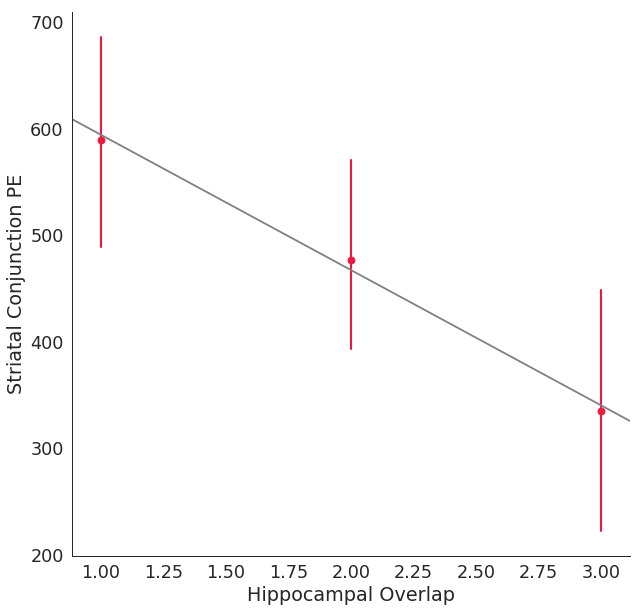

In [937]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (4, 8)})
sns.set_style("white")
test = performance.set_index('sub').copy()
for sub in set(test.index):
        vals = test.loc[sub,'hipp'].values
        rank = scipy.stats.rankdata(vals)
        test.loc[sub,'rank'] = rank
test = test.reset_index()
test.to_csv('/home/iballard/Dropbox/fd/paper/data/hipp_conj_pe.csv', index = False)

sns.regplot(x="rank", y="PE_mb",x_bins = 3,x_estimator = np.mean, data=test, x_ci = 68, ci = None,
            color = 'Blue',
           line_kws = {'color':'grey'},
           scatter_kws = {'color':'#ED1941'})
plt.ylabel('Striatal Conjunction PE')
plt.xlabel('Hippocampal Overlap')
sns.set_style({'font.family': 'Times New Roman'})
sns.despine()
# plt.savefig('/home/iballard/Dropbox/fd/figs/paper/hpc_striatum_overlap.png', dpi = 300,
#            bbox_inches = 'tight')

(0.3793577985932638, 0.035310703227555564)

/home/iballard/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


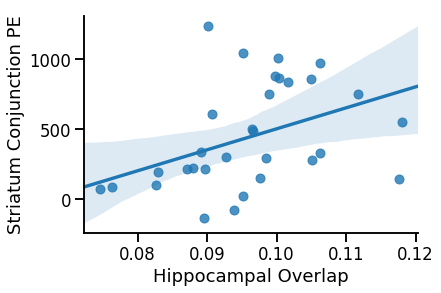

In [69]:
# agg_performance['overlap'] = agg_performance['overlap']*-1
sns.set_context('talk')
sns.regplot(x = 'hipp',y = 'PE_mb',data = agg_performance, robust = True)
sns.despine()
plt.ylabel('Striatum Conjunction PE')
plt.xlabel('Hippocampal Overlap')
# plt.xlabel('Hippocampal Within-Category Coding')
sns.set_style({'font.family': 'Times New Roman'})

# plt.savefig('/home/iballard/Dropbox/fd/figs/paper/correlation_hpc_striatum_overlap.png', dpi = 300,
#            bbox_inches = 'tight')
scipy.stats.pearsonr(agg_performance['hipp'],agg_performance['PE_mb'] )

# Assess relationship between HPC within-stimulus coding and Striatal PE

7.09694700189


Text(0.5,0,'Hippocampal Within-Stimulus Coding')

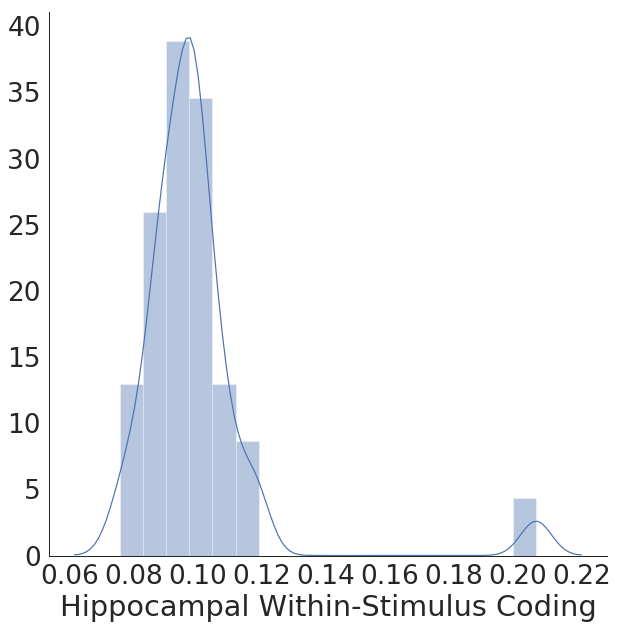

In [919]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_context('paper',font_scale = 3)
sns.set_style("white")
sns.distplot(agg_performance['hipp'])
sns.set_context('paper')
mean =performance['hipp'].mean()
sd = performance['hipp'].std()
print (max(performance['hipp']) - mean)/sd
sns.despine()
plt.xlabel('Hippocampal Within-Stimulus Coding')
# plt.savefig('/home/iballard/Dropbox/fd/figs/paper/identity.png', dpi = 300,
#            bbox_inches = 'tight')

In [845]:
fdrcorrection([.027, .22, .056, .75, .3 ],.05)
print performance[performance['hipp'] > .2]

         idx        V1      hipp  mOFC_fill_sim  para_sim  peri_sim  \
48  fd_127.1  0.166144  0.255081      -0.000634  0.263235  0.223988   

    yeo17_ifs     sub  run  diff_rsa       PE_mb       PE_mf  diff_conj  \
48   0.115798  fd_127    1   0.01147  731.002771  635.326217   0.872895   

    diff_null  
48   2.876404  


In [855]:
performance_clean = performance[performance['hipp'] < .2].dropna(subset = ['diff_null'])

var = 'hipp'
model_str = 'PE_mb ~  + ' + var
mixedfx = smf.mixedlm(model_str, performance_clean, groups = performance_clean['sub'])
mixedfx = mixedfx.fit()
print mixedfx.tvalues[var]
e =  mixedfx.bse[var]
dz = mixedfx.params[var] / (e * np.sqrt(len(subs)-1))
print 'dz', dz
print mixedfx.summary()

2.1963382127713693
dz 0.39447398805774886
            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  PE_mb      
No. Observations:   89       Method:              REML       
No. Groups:         31       Scale:               324284.5563
Min. group size:    1        Likelihood:          -677.1965  
Max. group size:    3        Converged:           Yes        
Mean group size:    2.9                                      
-------------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|   [0.025    0.975] 
-------------------------------------------------------------
Intercept  -441.429  419.228 -1.053 0.292 -1263.100   380.243
hipp       9451.953 4303.505  2.196 0.028  1017.238 17886.669
groups RE 12047.890   68.848                                 



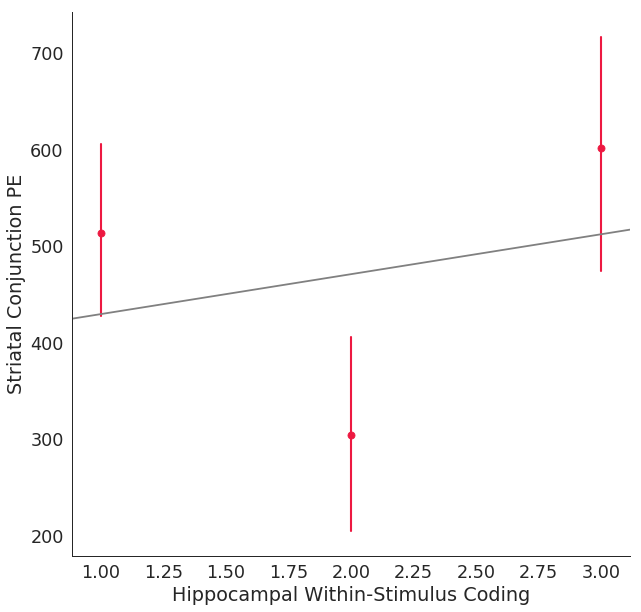

In [923]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (4, 8)})
sns.set_style("white")
test = performance.set_index('sub').copy()
for sub in set(test.index):
    vals = test.loc[sub,'hipp']
    rank = scipy.stats.rankdata(vals)
    test.loc[sub,'rank'] = rank
test = test.reset_index()
test.to_csv('/home/iballard/Dropbox/fd/paper/data/hipp_conj_pe_identity.csv', index = False)
sns.regplot(x="rank", y="PE_mb",x_bins = 3,x_estimator = np.mean, data=test, x_ci = 68, ci = None,
            color = 'Blue',
           line_kws = {'color':'grey'},
           scatter_kws = {'color':'#ED1941'})
plt.ylabel('Striatal Conjunction PE')
plt.xlabel('Hippocampal Within-Stimulus Coding')
sns.set_style({'font.family': 'Times New Roman'})
sns.despine()
# plt.savefig('/home/iballard/Dropbox/fd/figs/paper/hpc_striatum_identity.png', dpi = 300,
#            bbox_inches = 'tight')

(0.42009471890396721, 0.016674486967070128)

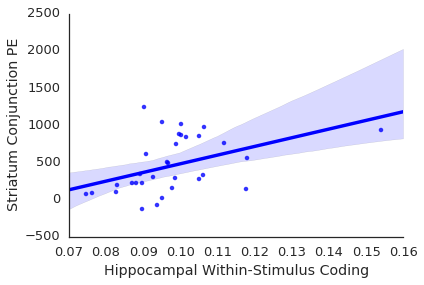

In [48]:
agg_performance_clean = performance_clean.groupby('sub').mean()
sns.set_context('talk')
sns.regplot(x = 'identity',y = 'PE_mb',data = agg_performance_clean, robust = True)
sns.despine()
plt.ylabel('Striatum Conjunction PE')
plt.xlabel('Hippocampal Within-Stimulus Coding')
sns.set_style({'font.family': 'Times New Roman'})

plt.savefig('/home/iballard/Dropbox/fd/figs/paper/correlation_hpc_striatum_identity.png', dpi = 300,
           bbox_inches = 'tight')
scipy.stats.pearsonr(agg_performance_clean['identity'],agg_performance_clean['PE_mb'] )

# Assess relationship betrween behavior and striatal PE

In [940]:
#load model fits
model_fits = pd.read_csv('/home/iballard/fd/model_fits.csv')

#load parameter estimates
leak = pd.read_csv('/home/iballard/Dropbox/fd/rt_fitting/df_brain.csv')
leak = leak[leak['alg'] == 'leak_RL']
leak = leak[['sub','omega','alpha']]

# #merge dataframes
agg_performance = pd.DataFrame(agg_performance.to_records())
agg_performance = pd.merge(agg_performance, model_fits, on=['sub'])
agg_performance = pd.merge(agg_performance, leak, on=['sub'])
agg_performance = agg_performance[agg_performance['sub'] != 'fd_122'] #no data
print agg_performance.shape

(31, 14)


In [955]:
leak = pd.read_csv('/home/iballard/Dropbox/fd/rt_fitting/df_brain.csv')
l = leak[leak['alg'] == 'leak_RL']
l.to_csv('/home/iballard/Dropbox/fd/paper/data/best_params.csv', index = False)

In [941]:
model_str = 'PE_mb ~ diff_null + omega'
ols = smf.ols(model_str, agg_performance)
ols = ols.fit()
e =  ols.bse['diff_null']
dz = ols.params['diff_null'] / (e * np.sqrt(len(subs)-1))
print 'diff_null', dz
e =  ols.bse['omega']
dz = ols.params['omega'] / (e * np.sqrt(len(subs)-1))
print 'dz_omega', dz
print ols.summary()

diff_null -0.5096993234663231
dz_omega -0.4278146511422853
                            OLS Regression Results                            
Dep. Variable:                  PE_mb   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.139
Date:                Wed, 05 Dec 2018   Prob (F-statistic):             0.0266
Time:                        22:49:13   Log-Likelihood:                -223.09
No. Observations:                  31   AIC:                             452.2
Df Residuals:                      28   BIC:                             456.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [945]:
agg_performance.to_csv('/home/iballard/Dropbox/fd/paper/data/hipp_conj_pe_between.csv', index = False)

In [484]:
model_str = 'PE_mb ~ diff_null + omega'
ols = smf.ols(model_str, agg_performance)
ols = ols.fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PE_mb   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.139
Date:                Wed, 21 Mar 2018   Prob (F-statistic):             0.0266
Time:                        13:07:11   Log-Likelihood:                -223.09
No. Observations:                  31   AIC:                             452.2
Df Residuals:                      28   BIC:                             456.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1188.4589    265.632      4.474      0.000     644.335    1732.582
diff_null  -2218.5927    781.777     -2.838      0.008   -3819.989    -617.196
omega       -884.8696    371.486     -2.382      0.024   -1645.825    -123.914
==============================================================================
Omnibus:                        1.257   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.076
Skew:                           0.255   Prob(JB):                        0.584
Kurtosis:                       2.243   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""